# Importing necessary packages

In [1]:
import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import Trials, tpe, hp, fmin, space_eval
from hyperopt.pyll import scope
import shap

import warnings

# Ignore all future warnings in Jupyter notebook
warnings.filterwarnings('ignore', category=FutureWarning)
np.random.seed(8)

# Data importing and preperation

In [2]:
project_path=os.getcwd()
df2= os.path.join(project_path,"data/dataset2.csv")
df2 = pd.read_csv(df2)
df_type='dataset2'
df2.columns=['Cmix', 'wc_u','wc_std', 'Vp_u','Pv_std','Yd_u','Yd_std', # Table 1
             'ξg_u','ξg_std','Xog_u','Xog_std','ξp_u','ξp_std','Xop_u','Xop_std','dp_u','dp_std','dpmax_u','dpmax_std','po_u','po_std', # Tabl2
             'φ','h','m','ρ','Fmax','CS']
df2.describe().T.to_csv(f'results/{df_type}_statSumm.csv')
df2.describe()

,wc_u,wc_std,Vp_u,Pv_std,Yd_u,Yd_std,ξg_u,ξg_std,Xog_u,Xog_std,...,dpmax_u,dpmax_std,po_u,po_std,φ,h,m,ρ,Fmax,CS
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,...,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,3.917837,0.318406,4142.364516,190.251613,36.451992,3.475901,2.039658,0.253131,13.051233,3.940417,...,4.816698,0.999241,2.669639,0.565465,94.344592,186.690323,375.570398,2323.006831,351.719355,43.563188
std,0.994827,0.121863,258.018718,54.836286,5.851027,1.179534,1.209941,0.222551,6.481937,3.089166,...,1.380385,0.357483,1.676597,0.268326,45.423488,86.986703,511.854957,105.399701,282.270189,7.231407
min,2.900000,0.100000,3782.400000,121.700000,27.900000,2.000000,0.500000,0.000000,5.100000,0.600000,...,2.500000,0.500000,1.100000,0.200000,39.000000,74.000000,4.500000,2084.200000,34.400000,28.800000
25%,3.100000,0.200000,3808.100000,135.500000,28.900000,2.200000,0.600000,0.100000,6.300000,0.800000,...,3.700000,0.600000,1.600000,0.400000,39.000000,82.000000,9.200000,2204.800000,83.000000,38.600000
50%,3.400000,0.300000,4268.600000,166.000000,39.100000,3.200000,2.000000,0.200000,11.100000,3.300000,...,4.500000,1.000000,1.900000,0.500000,69.500000,142.000000,209.000000,2378.800000,216.800000,42.200000
75%,5.200000,0.400000,4343.900000,225.700000,40.900000,4.400000,3.200000,0.300000,15.900000,5.800000,...,6.500000,1.200000,3.900000,0.700000,112.300000,223.000000,1155.000000,2407.550000,471.050000,46.500000
max,5.400000,0.500000,4476.200000,293.900000,43.800000,5.300000,3.800000,0.800000,27.800000,11.100000,...,6.900000,1.800000,6.200000,1.200000,160.800000,318.300000,1304.000000,2465.100000,944.600000,71.300000


## Getting the correlation of featrues

In [3]:
df2_corr = df2.copy()
df2_corr['Cmix'] = pd.factorize(df2_corr['Cmix'])[0]
df2_corr = df2_corr.corr().round(4)
df2_corr.to_csv(f'data/{df_type}_corrSummary.csv')
df2_corr

,Cmix,wc_u,wc_std,Vp_u,Pv_std,Yd_u,Yd_std,ξg_u,ξg_std,Xog_u,...,dpmax_u,dpmax_std,po_u,po_std,φ,h,m,ρ,Fmax,CS
Cmix,1.0000,-0.8450,-0.3357,0.8639,0.7710,0.8600,0.8314,0.9899,0.7850,0.7478,...,-0.2808,-0.1441,-0.8243,-0.5779,-0.0135,-0.0053,0.0267,0.8657,-0.0980,-0.5497
wc_u,-0.8450,1.0000,0.5905,-0.9396,-0.6621,-0.9335,-0.7788,-0.8725,-0.6116,-0.7496,...,0.0687,0.0753,0.9385,0.7156,-0.1585,-0.1696,0.0942,-0.9184,-0.0838,0.5267
wc_std,-0.3357,0.5905,1.0000,-0.4412,-0.3790,-0.4117,-0.4346,-0.3714,-0.1539,-0.6696,...,-0.4759,-0.0765,0.4600,0.5375,-0.5540,-0.5611,0.3034,-0.3614,-0.5102,0.4241
Vp_u,0.8639,-0.9396,-0.4412,1.0000,0.5305,0.9943,0.6777,0.8725,0.5477,0.7211,...,-0.1927,-0.1408,-0.8705,-0.6493,0.0006,0.0114,0.1468,0.9427,-0.0886,-0.4373
Pv_std,0.7710,-0.6621,-0.3790,0.5305,1.0000,0.5569,0.9763,0.7672,0.8963,0.5269,...,-0.2953,-0.2477,-0.6230,-0.5350,-0.0607,-0.0542,-0.4088,0.6512,-0.0947,-0.3821
Yd_u,0.8600,-0.9335,-0.4117,0.9943,0.5569,1.0000,0.6994,0.8637,0.5885,0.6622,...,-0.2672,-0.2099,-0.8653,-0.6448,-0.0900,-0.0788,0.1585,0.9620,-0.1711,-0.3919
Yd_std,0.8314,-0.7788,-0.4346,0.6777,0.9763,0.6994,1.0000,0.8322,0.8844,0.6034,...,-0.2707,-0.2171,-0.7342,-0.6153,-0.0516,-0.0446,-0.3617,0.7671,-0.1027,-0.4102
ξg_u,0.9899,-0.8725,-0.3714,0.8725,0.7672,0.8637,0.8322,1.0000,0.7912,0.7735,...,-0.2389,-0.1353,-0.8426,-0.6208,0.0600,0.0695,-0.0031,0.8696,-0.0200,-0.5739
ξg_std,0.7850,-0.6116,-0.1539,0.5477,0.8963,0.5885,0.8844,0.7912,1.0000,0.3618,...,-0.5370,-0.4452,-0.6235,-0.5808,-0.2644,-0.2566,-0.1492,0.7013,-0.2722,-0.3296
Xog_u,0.7478,-0.7496,-0.6696,0.7211,0.5269,0.6622,0.6034,0.7735,0.3618,1.0000,...,0.2585,0.1824,-0.6621,-0.5083,0.5466,0.5547,-0.1833,0.5838,0.4524,-0.6006


## One Hot Encoding of catergorical variables

In [4]:
df_encoded = df2.copy()
encoder = OneHotEncoder(cols=['Cmix'], use_cat_names=True)
df_encoded = encoder.fit_transform(df_encoded)
df_encoded['Cmix']=df2['Cmix']

## Data partitioning into training, validation and testing datasets

In [5]:
Input_features = df_encoded.columns.drop('CS')
X = df_encoded[Input_features]
y = df_encoded['CS']
# Splitting the data into training, temporary test, and validation sets (80%, 10%, 10%) with stratified split based on 'Cmix_merge'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2, stratify=X['Cmix'])
X_train_wo_valid, X_val, y_train_wo_valid, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2, stratify=X_train['Cmix'])
X_train = X_train.drop(columns=['Cmix'])
X_train_wo_valid = X_train_wo_valid.drop(columns=['Cmix'])
X_test = X_test.drop(columns=['Cmix'])
X_val = X_val.drop(columns=['Cmix'])
print(X_train.columns)

Index(['Cmix_F', 'Cmix_M', 'Cmix_C', 'wc_u', 'wc_std', 'Vp_u', 'Pv_std',
       'Yd_u', 'Yd_std', 'ξg_u', 'ξg_std', 'Xog_u', 'Xog_std', 'ξp_u',
       'ξp_std', 'Xop_u', 'Xop_std', 'dp_u', 'dp_std', 'dpmax_u', 'dpmax_std',
       'po_u', 'po_std', 'φ', 'h', 'm', 'ρ', 'Fmax'],
      dtype='object')


# TPE optimization of xgboost

In [6]:
def objFun(params):
        model = XGBRegressor(**params, random_state=np.random.RandomState(11), n_jobs=-1)
        model.fit(X_train_wo_valid, y_train_wo_valid)    
        predict_val = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, predict_val)
        return rmse
space={'n_estimators': scope.int(hp.quniform('n_estimators', 50, 10000,1)),
        'min_split_loss': scope.float(hp.uniform('min_split_loss', 0.0001, 1.0)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 7,1)),
            'subsample': scope.float(hp.uniform('subsample', 0.9, 1)),
            'reg_alpha': scope.float(hp.uniform('reg_alpha', 0.01, 1.0)),
            'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
            'learning_rate': scope.float(hp.uniform('learning_rate', 0.01, 0.20)),
            'colsample_bylevel': scope.float(hp.uniform('colsample_bylevel', 0.9, 1)),
            'colsample_bytree': scope.float(hp.uniform('colsample_bytree', 0.9, 1)),
        }
trials = Trials()
rng = np.random.default_rng(11)
best = fmin(fn=objFun,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials,
            rstate=rng)

xgb_best=best
best_hyperparams =  space_eval(space, xgb_best)   
best_hyperparams.update({'RMSE': trials.best_trial['result']['loss']})
pd.DataFrame.from_dict([best_hyperparams]).to_csv(f'results/{df_type}_best_hyperparams.csv', index=False)

100%|██████████| 500/500 [42:06<00:00,  5.05s/trial, best loss: 0.5897716557216806]  


In [7]:
with open( f'results/{df_type}_xgb_traisl.pkl', 'wb') as file:
    pickle.dump(trials, file)
with open(f'results/{df_type}_xgb_best.pkl', 'wb') as file:
    pickle.dump(best, file)

## Comparison with other ML methods

In [8]:
model_list = ['TPE_xgboost','xboost_naïve','RF', 'SVM','ANN']
res_dic = {}
for idx, model_name in enumerate(model_list):
    if model_name == 'TPE_xgboost':
        df_best_hyperparams=pd.read_csv(f'results/{df_type}_best_hyperparams.csv')
        model = XGBRegressor(n_estimators=df_best_hyperparams['n_estimators'].values[0],
                            max_depth=df_best_hyperparams['max_depth'].values[0],
                            min_split_loss=df_best_hyperparams['min_split_loss'].values[0],
                            reg_alpha=df_best_hyperparams['reg_alpha'].values[0],
                            grow_policy=df_best_hyperparams['grow_policy'].values[0],
                            colsample_bylevel=df_best_hyperparams['colsample_bylevel'].values[0],
                            colsample_bytree=df_best_hyperparams['colsample_bytree'].values[0],
                            learning_rate=df_best_hyperparams['learning_rate'].values[0],
                            subsample=df_best_hyperparams['subsample'].values[0],
                            random_state=11,
                            n_jobs=-1)
        model.fit(X_train, y_train)
        # Save the trained model
        xgb_opt_path = f'results/{df_type}_xgb_opt.pkl'
        with open(xgb_opt_path, 'wb') as file:
            pickle.dump(model, file)
    elif model_name == 'xboost_naïve':
        model =  XGBRegressor(random_state=8)
        model.fit(X_train, y_train)
    elif model_name == 'RF':
        model = RandomForestRegressor(random_state=8)
        model.fit(X_train, y_train)
    elif model_name == 'SVM':
        model = SVR(kernel='rbf')
        model.fit(X_train, y_train)
    elif model_name == 'ANN':
        model = MLPRegressor(random_state=8)
        model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    r2_train = r2_score(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    predictions_val = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
    r2_val = r2_score(y_val, predictions_val)
    mae_val = mean_absolute_error(y_val, predictions_val)
    predictions_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    r2_test = r2_score(y_test, predictions_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    res_dic[f'{model_name}'] = {'RMSE_training': rmse_train,
                                'RMSE_validation': rmse_val,
                                'RMSE_testing': rmse_test,
                                'R2_training': r2_train,
                                'R2_validation': r2_val,
                                'R2_testing': r2_test,
                                'MAE_training': mae_train,
                                'MAE_validation': mae_val,
                                'MAE_testing': mae_test}
results_df=pd.DataFrame.from_dict(res_dic)
results_df

C:\Users\zeshan\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,TPE_xgboost,xboost_naïve,RF,SVM,ANN
RMSE_training,0.091674,0.046315,0.339600,6.755517,3.258554
RMSE_validation,0.090512,0.046324,0.248412,8.004288,3.368403
RMSE_testing,0.681269,0.687312,0.874756,5.441403,3.092969
R2_training,0.999844,0.999960,0.997860,0.153039,0.802941
R2_validation,0.999878,0.999968,0.999083,0.047876,0.831385
R2_testing,0.987438,0.987214,0.979290,0.198622,0.741079
MAE_training,0.064000,0.032232,0.186411,4.719570,2.393087
MAE_validation,0.064850,0.033363,0.158792,5.617712,2.366697
MAE_testing,0.469075,0.500308,0.523943,3.884404,2.329331


In [9]:
results_df.to_csv(f'results/{df_type}results.csv')

## Ploting optimizaiton resusts

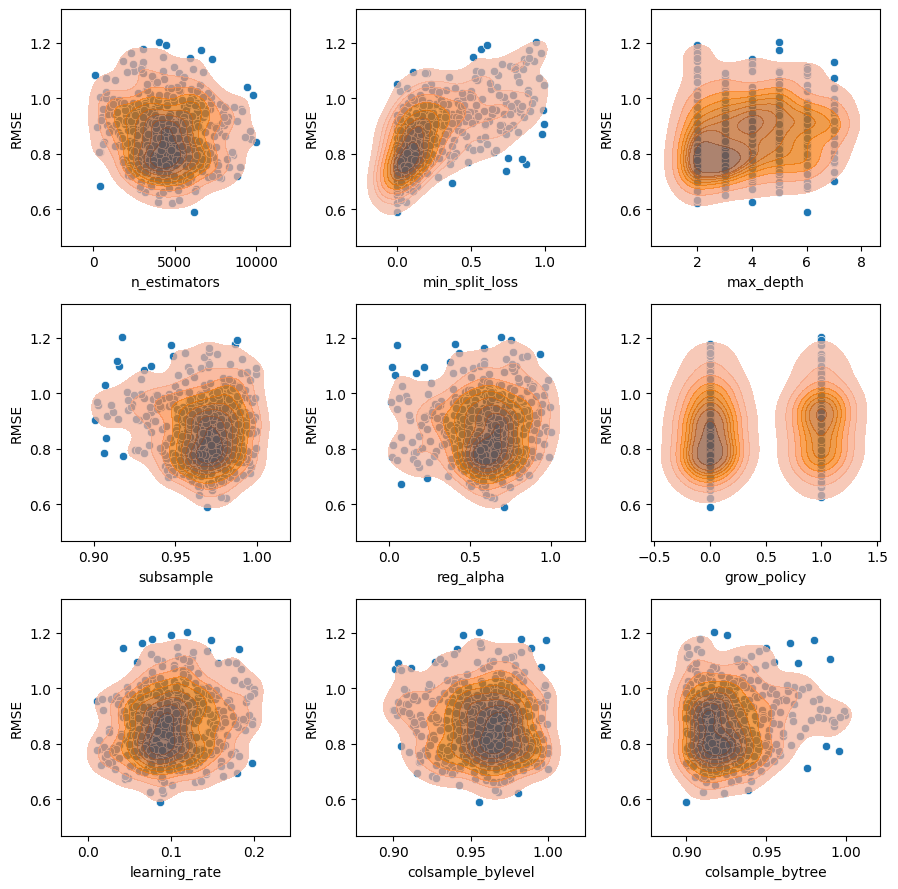

In [10]:
with open( f'results/{df_type}_xgb_traisl.pkl', 'rb') as file:
    trials = pickle.load(file)
with open(f'results/{df_type}_xgb_best.pkl', 'rb') as file:
    xgb_best = pickle.load(file)

losses = [trial['result']['loss'] for trial in trials.trials]
q3 = np.percentile(losses, 75)
upper_bound = q3 + 1.5 * (q3 - np.percentile(losses, 25))
filtered_trials = [trial for trial in trials.trials if trial['result']['loss'] <= upper_bound]
df_trials = pd.DataFrame([{**{k: v[0] for k, v in trial['misc']['vals'].items()}, 'loss': trial['result']['loss']} for trial in filtered_trials])

hyperparameters = ['n_estimators', 'min_split_loss', 'max_depth', 'subsample', 'reg_alpha', 'grow_policy',
                   'learning_rate', 'colsample_bylevel', 'colsample_bytree']
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()
min_loss_index = df_trials['loss'].idxmin()
for i, hyperparam in enumerate(hyperparameters):
    ax = axes[i]
    sns.scatterplot(x=hyperparam, y='loss', data=df_trials, ax=ax)
    sns.kdeplot(y='loss',data=df_trials, x=hyperparam, ax=ax, fill=True, alpha=.7)
    ax.set_xlabel(hyperparam)
    ax.set_ylabel('RMSE')
    best_hyperparam_value = df_trials.loc[min_loss_index, hyperparam]
    best_loss = df_trials.loc[min_loss_index, 'loss']
plt.tight_layout()
plt.savefig(f'results/{df_type}_trailsvsloss.svg', format='svg')
plt.savefig(f'results/{df_type}_trailsvsloss.png', format='png')
plt.show()
plt.close()

In [11]:
# Load the saved model
with open(xgb_opt_path, 'rb') as file:
    model = pickle.load(file)

## Plotting the diagnostic curves

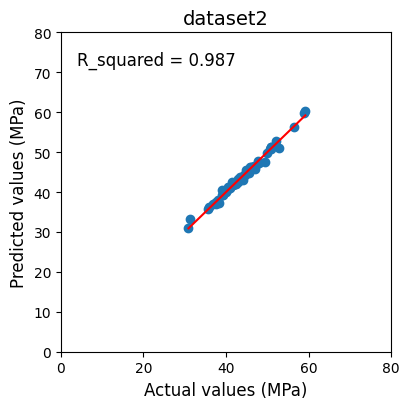

In [12]:
plt.figure(figsize=(4.2, 4.2))
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('Actual values (MPa)', fontsize=12)
plt.ylabel('Predicted values (MPa)', fontsize=12)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.annotate(f"R_squared = {results_df['TPE_xgboost']['R2_testing']:.3f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.title('dataset2', fontsize=14)
plt.ylim([0, 80])  # Set the y-axis limits to -10 and 10
plt.xlim([0, 80]) 
plt.tight_layout()

plt.savefig(f'results/{df_type}_predvsact.svg', format='svg',dpi=600)
plt.savefig(f'results/{df_type}_predvsact.png', format='png',dpi=600)
plt.show()
plt.close()

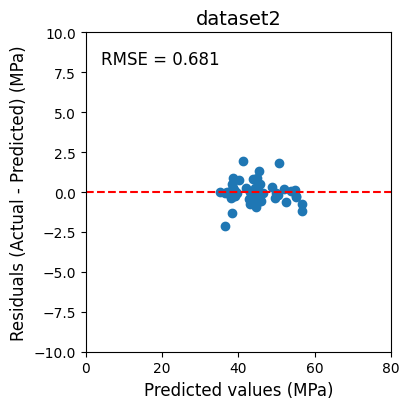

In [13]:
plt.figure(figsize=(4.2, 4.2))
residuals = y_test - model.predict(X_test)
plt.scatter(predictions_test, residuals)
plt.xlabel('Predicted values (MPa)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted) (MPa)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--')
plt.annotate(f"RMSE = {results_df['TPE_xgboost']['RMSE_testing']:.3f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.title('dataset2', fontsize=14)
plt.ylim([-10, 10])  # Set the y-axis limits to -10 and 10
plt.xlim([0, 80]) 
plt.tight_layout()

plt.savefig(f'results/{df_type}_residualvspred.svg', format='svg', dpi=600)
plt.savefig(f'results/{df_type}_residualvspred.png', format='png',dpi=600)
plt.show()
plt.close()

# Explainability analyses and results

In [14]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9555787072157296, colsample_bynode=None,
             colsample_bytree=0.9000415889209314, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0865577259638191, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, min_split_loss=0.0018825037547949,
             missing=nan, monotone_constraints=None, n_estimators=6175,
             n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

In [15]:
df_exp = X_test[X_test.columns]
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_exp)

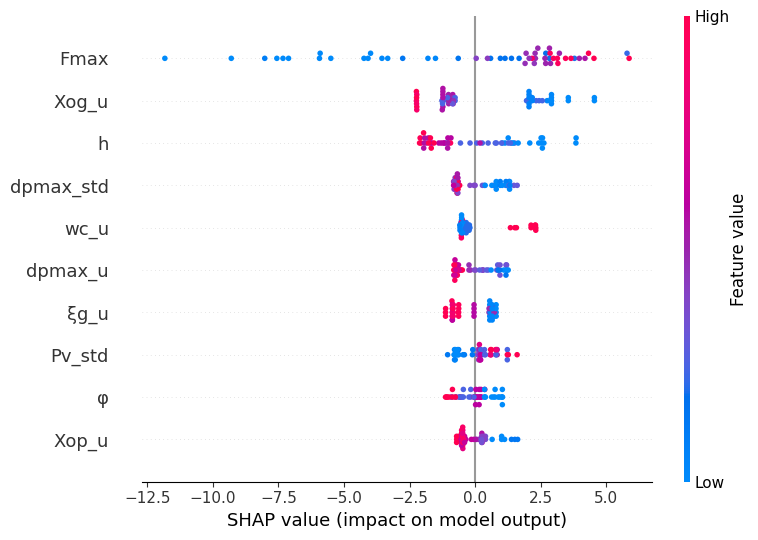

In [16]:
%matplotlib inline 
plt.figure()
shap.summary_plot(shap_values, df_exp, feature_names=df_exp.columns, max_display=10, show=False)
plt.savefig(f'results/{df_type}_shapfeatimp.svg', format='svg', dpi=600, bbox_inches='tight')
plt.savefig(f'results/{df_type}_shapfeatimp.png', format='png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

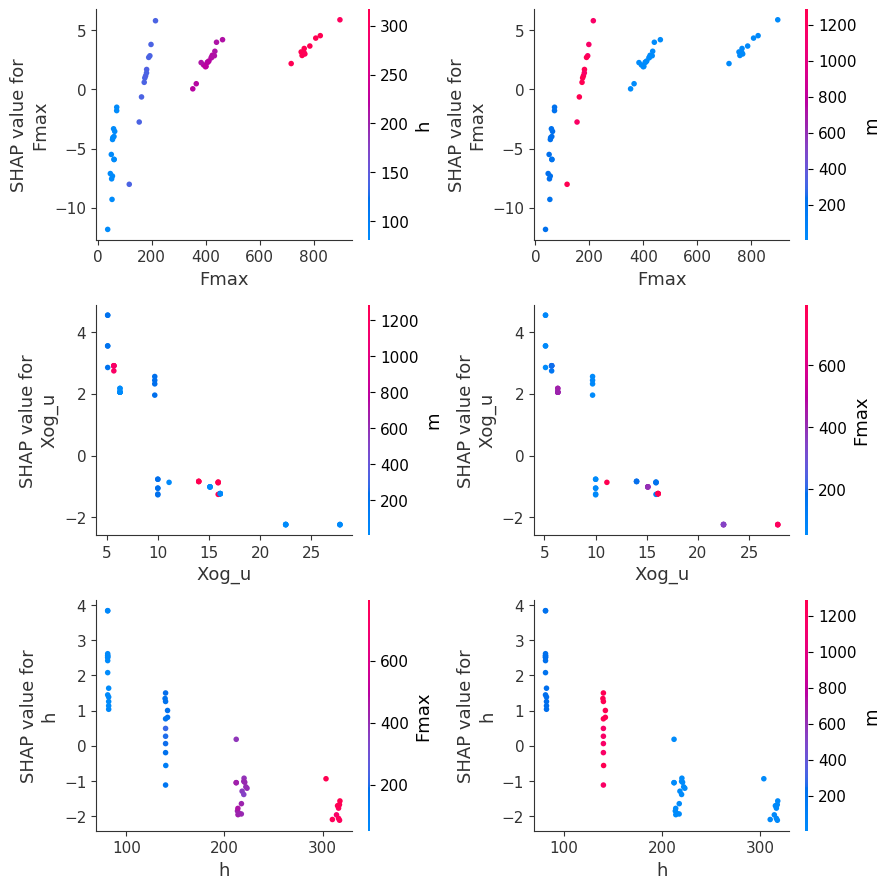

In [23]:
%matplotlib inline 
shap_values = explainer.shap_values(X_test[X_test.columns])
top_3_features= ["Fmax","Xog_u","h"]
fig, axes = plt.subplots(len(top_3_features), 2, figsize=(9, 9))
for feat_level, feat in enumerate(top_3_features):
    # print(f'{feat_level}:{feat}')
    inds = shap.approximate_interactions(feat, shap_values, df_exp)
    # print(inds)
    # shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i])
    for i in range(2):
        # print(feat_level, i)
        ax = axes[feat_level, i]
        # print(ax)
        # plt.subplot(len(top_3_features), 2, feat_level * 2 + (i + 1))  # Specify subplot position
        shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i], ax=ax, show=False) 
        # shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i],ax=ax)
plt.tight_layout()
plt.savefig(f'results/{df_type}_all_interactions.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()
plt.close()